Author: Xiaogang He (hexg@princeton.edu), http://hydro.iis.u-tokyo.ac.jp/~hexg

The `%matplotlib` magic command is used here to enable plotting in the current notebook. The `inline` backend will embed plots inside the notebook.

In [1]:
%matplotlib inline

### Import necessary modules 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

### Read USGS observations

We will define a python function and use **pandas** to read the USGS peak discharge data (in standard text format) and assign the names for each column. 

In [3]:
def read_peak_discharge(gageID):
    df = pd.read_csv('../Data/%s.txt' % (gageID), header=None, names=['Year', 'Month', 'Day', 'Discharge', 'Stage'])

    return df

Read the dataframe using the customed function:

In [4]:
obs = read_peak_discharge('01401000')

In [5]:
obs

,Year,Month,Day,Discharge,Stage
0,1897,12,16,72800,NaN
1,1899,3,7,69200,NaN
2,1900,3,2,104000,NaN
3,1901,3,22,77600,NaN
4,1902,3,2,214000,23.60
5,1903,3,1,134000,NaN
6,1903,10,11,295000,28.50
7,1905,3,28,88500,NaN
8,1906,4,16,112000,NaN
9,1907,1,26,NaN,16.80


Get the date information and convert the calendar year to water year (Oct-Apr):

In [6]:
year = obs['Year']
month = obs['Month']
waterYear=[year[i]+1 if month[i]>9 else year[i] for i in range(len(year))]

In [16]:
peak = obs['Discharge']

### Plot annual peak discharge observations

We will use matplotlib for basic plots.

(0, 117)

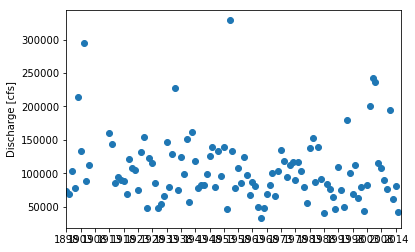

In [8]:
plt.scatter(range(len(peak)), peak)
plt.ylabel('Discharge [cfs]')
plt.xticks(range(len(year))[::5], waterYear[::5])
plt.xlim([0,len(peak)])

## Use rpy2 to access R from within python

### Convert the format from python to R

In [17]:
peak = FloatVector(peak[~np.isnan(peak)])
r.assign('peak', peak)

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1141913f8 / R:0x114579a40>
[72800.000000, 69200.000000, 104000.000000, ..., 61600.000000, 80200.000000, 41500.000000]

### Test for trend in annual peak data

MannKendall test is used to detect monotonic trend based on Kendall rank correaltion. We need to import the R package `Kendall` at first.

In [18]:
importr('Kendall')
print r("MannKendall(peak)")

tau = -0.09, 2-sided pvalue =0.16254



### Test for change point in annual peak data

We will use `strucchange` package and call its `breakpoints` function to detect the changing point.

In [20]:
importr('strucchange')
r("bp.peak <- breakpoints(peak ~ 1)")
print r("bp.peak$breakpoints")

[1] NA



###  Calculate the return period

In [12]:
def calculate_return_period(EVD, rp):

    """
    This is a function to calculate the return level of flood peaks using GEV and Gumbel
    
    Args:
        :EVD (str): extreme value distribution, e.g., 'GEV' or 'Gumbel'
        :rp (int): return period, e.g., 10, 20, 50, 100
    
    """
    
    importr('ismev')
    r.assign('rp', rp)

    if EVD == 'GEV':
        r("fit.obj <- gev.fit(peak)")            # Maximum-likelihood fitting for the GEV distribution
        pars = r("pars <- fit.obj$mle")          # Return the GEV parameters (location, scale and shape) 
        pars_se = r("pars <- fit.obj$se")        # Return the standard error of the GEV parameters
        rl = r("gevq(fit.obj$mle, 1./rp)")[0]    # Calculate the quantile of GEV distribution given the exceedence probability
        r.pdf(file='./%s_diag.pdf' % (EVD), width=8, height=8)
        r("gev.diag(fit.obj)")                   # Produces diagnostic plots for GEV models using the output of the function gev.fit
        r("dev.off()")
    elif EVD == 'Gumbel':
        r("fit.obj <- gum.fit(peak)")
        pars = r("pars <- fit.obj$mle")
        pars_se = r("pars <- fit.obj$se")
        rl = r("gum.q(1.0/rp, pars[1], pars[2])")[0]
        r.pdf(file='./%s_diag.pdf' % (EVD), width=8, height=8)
        r("gum.diag(fit.obj)")
        r("dev.off()")

    return rl, pars, pars_se

If we want to get the **100**-year flood peak from the **GEV** distribution, we can just:

In [21]:
rl_gev, pars_gev, pars_se_gev = calculate_return_period('GEV', 100)
print "The estimated return level using GEV distribution is %.2f cfs" %rl_gev
print "The estimated GEV parameters are locaton=%.2f, scale=%.2f, shape=%.2f" %(pars_gev[0], pars_gev[1], pars_gev[2])
print "Standard errors corresponding to the estimated GEV parameters are locaton=%.2f, scale=%.2f, shape=%.2f" %(pars_se_gev[0], pars_se_gev[1], pars_se_gev[2])

$conv
[1] 0

$nllh
[1] 1336.529

$mle
[1] 8.221536e+04 3.275664e+04 1.165287e-01

$se
[1] 1.385927e+04 7.278183e+03 1.121004e-01

The estimated return level using GEV distribution is 281585.56 cfs
The estimated GEV parameters are locaton=82215.36, scale=32756.64, shape=0.12
Standard errors corresponding to the estimated GEV parameters are locaton=13859.27, scale=7278.18, shape=0.11


Similarly, if we want to get the **100**-year flood peak from the **Gumbel** distribution, we just need to change the first argument in the function:

In [22]:
rl_gum, pars_gum, pars_se_gum = calculate_return_period('Gumbel', 100)
print "The estimated return level using Gumbel distribution is %.2f cfs" %rl_gum
print "The estimated Gumbel parameters are locaton=%.2f, scale=%.2f" %(pars_gum[0], pars_gum[1])
print "Standard errors corresponding to the estimated Gumbel parameters are locaton=%.2f, scale=%.2f" %(pars_se_gum[0], pars_se_gum[1])

$conv
[1] 0

$nllh
[1] 1338.19

$mle
[1] 84392.28 34385.23

$se
[1] 3248.894 2652.711

The estimated return level using Gumbel distribution is 15451.76 cfs
The estimated Gumbel parameters are locaton=84392.28, scale=34385.23
Standard errors corresponding to the estimated Gumbel parameters are locaton=3248.89, scale=2652.71
